<a href="https://www.kaggle.com/code/sjain600/lightbm-model-with-feature-importances?scriptVersionId=233604688" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

## Data Understanding

In [3]:
train.shape

(1200000, 21)

In [4]:
test.shape

(800000, 20)

In [5]:
train.sample(10)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
574094,574094,21.0,Female,131811.0,Divorced,1.0,High School,<NA>,37.91867883,Rural,Premium,<NA>,12.0,410.0,4.0,2021-12-24 15:21:39.194829,Poor,Yes,Rarely,Apartment,619.0
170064,170064,44.0,Male,31006.0,Single,0.0,Master's,Self-Employed,47.82750835,Urban,Comprehensive,1.0,8.0,629.0,1.0,2024-01-07 15:21:39.097737,Good,Yes,Monthly,Apartment,2428.0
1002116,1002116,64.0,Female,23757.0,Divorced,2.0,Master's,<NA>,<NA>,Urban,Basic,1.0,17.0,734.0,1.0,2023-07-02 15:21:39.283783,Good,Yes,Daily,Apartment,739.0
50074,50074,51.0,Female,14982.0,Married,4.0,Bachelor's,<NA>,26.63793135,Rural,Basic,1.0,18.0,<NA>,7.0,2023-03-31 15:21:39.245086,Good,No,Daily,House,441.0
807101,807101,31.0,Male,45956.0,Married,<NA>,Master's,Employed,36.95651147,Urban,Comprehensive,1.0,13.0,759.0,2.0,2022-03-22 15:21:39.133866,Good,No,Weekly,Condo,1585.0
17940,17940,32.0,Male,121396.0,Married,3.0,Master's,Self-Employed,20.58985894,Urban,Basic,<NA>,8.0,439.0,4.0,2020-09-12 15:21:39.154008,Good,No,Weekly,Apartment,478.0
628389,628389,51.0,Female,758.0,Single,2.0,High School,Unemployed,<NA>,Urban,Comprehensive,<NA>,2.0,682.0,1.0,2022-09-04 15:21:39.155231,Good,No,Monthly,Apartment,449.0
131568,131568,33.0,Female,28983.0,Married,<NA>,High School,Employed,30.7394211,Suburban,Comprehensive,<NA>,6.0,584.0,8.0,2024-05-06 15:21:39.189223,Poor,No,Monthly,Apartment,2854.0
719550,719550,47.0,Female,14094.0,Single,0.0,High School,Employed,14.8270562,Suburban,Comprehensive,0.0,9.0,843.0,2.0,2020-01-17 15:21:39.134960,Good,Yes,Daily,House,981.0
214732,214732,58.0,Female,4877.0,Married,3.0,Bachelor's,Self-Employed,41.73894259,Urban,Comprehensive,1.0,18.0,791.0,5.0,2022-07-10 15:21:39.233485,Good,No,Monthly,Condo,2436.0


In [6]:
train.isnull().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [7]:
test.isnull().sum()

id                           0
Age                      12489
Gender                       0
Annual Income            29860
Marital Status           12336
Number of Dependents     73130
Education Level              0
Occupation              239125
Health Score             49449
Location                     0
Policy Type                  0
Previous Claims         242802
Vehicle Age                  3
Credit Score             91451
Insurance Duration           2
Policy Start Date            0
Customer Feedback        52276
Smoking Status               0
Exercise Frequency           0
Property Type                0
dtype: int64

In [8]:
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'])
train['year'] = train['Policy Start Date'].dt.year.astype('float32')
train['month'] = train['Policy Start Date'].dt.month.astype('float32')
train['day'] = train['Policy Start Date'].dt.day.astype('float32')
train['day_of_week'] = train['Policy Start Date'].dt.day_of_week.astype('float32')
train['seconds'] = (train['Policy Start Date'].astype(int) // 10**9).astype('float32')
train.drop('Policy Start Date', axis=1, inplace=True)

In [9]:
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'])
test['year'] = test['Policy Start Date'].dt.year.astype('float32')
test['month'] = test['Policy Start Date'].dt.month.astype('float32')
test['day'] = test['Policy Start Date'].dt.day.astype('float32')
test['day_of_week'] = test['Policy Start Date'].dt.day_of_week.astype('float32')
test['seconds'] = (test['Policy Start Date'].astype(int) // 10**9).astype('float32')
test.drop('Policy Start Date', axis=1, inplace=True)

In [10]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype
---  ------                --------------    -----
 0   id                    1200000 non-null  int64
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object
 7   Occupation            841925 non-null   object
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object
 10  Policy Type           1200000 non-null  object
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-null  floa

## Data Preparation
*  Converting object dtype into category for faster processing
*  Filling missing values
*  Encoding categorical values into numerical values

In [11]:
cat_cols = train.select_dtypes(include='object').columns
train[cat_cols] = train[cat_cols].astype('category')
test[cat_cols] = test[cat_cols].astype('category')

In [12]:
from sklearn.impute import SimpleImputer

simple = SimpleImputer(strategy='most_frequent')
cat_cols = train.select_dtypes(include='category').columns
train[cat_cols] = simple.fit_transform(train[cat_cols])
test[cat_cols] = simple.transform(test[cat_cols])

In [13]:
from cuml.preprocessing import TargetEncoder

te = TargetEncoder(n_folds=15, smooth=20, split_method='random', stat='mean', seed=340)
for col in cat_cols:
    te = TargetEncoder().fit(train[col], train['Premium Amount'])
    train[col] = te.transform(train[col])
    test[col] = te.transform(test[col])

In [14]:
simple = SimpleImputer(strategy='median')
num_cols = test.select_dtypes(exclude='object').columns
train[num_cols] = simple.fit_transform(train[num_cols])
test[num_cols] = simple.transform(test[num_cols])

## Feature engineering

In [15]:
features = ['Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type']

In [16]:
def add_features(df):
    for i, col1 in enumerate(features):
        for col2 in (features[i+1:]):
            new_col = f'{col1}_{col2}'
            df[new_col] = train[col1] * train[col2]
    return df
    

## Identifying outliers

<Axes: ylabel='Premium Amount'>

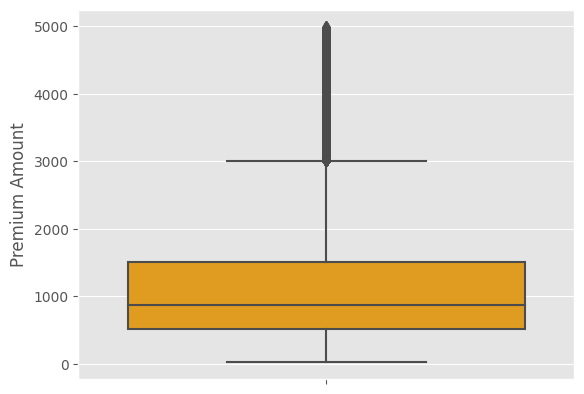

In [17]:
sns.boxplot(data=train, y='Premium Amount', color='orange')

Text(0.5, 1.0, 'Distribution plot of Annual Income')

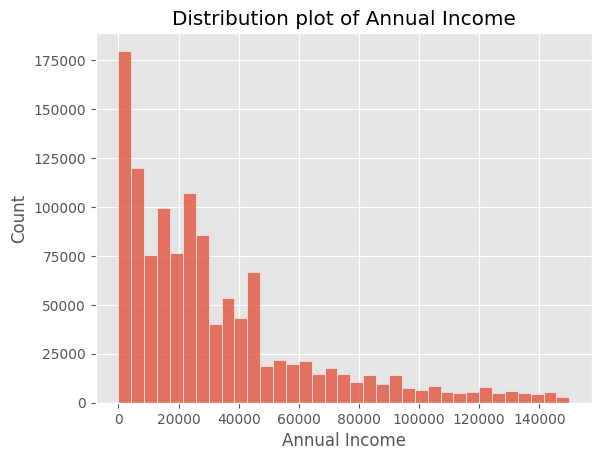

In [18]:
sns.histplot(x='Annual Income', data=train, bins=35)
plt.title('Distribution plot of Annual Income')

## Splitting the data for model prediction

In [19]:
from sklearn.model_selection import KFold

X = train.copy()
y = X.pop('Premium Amount')
X = add_features(X)
y = np.log(y)

X_test = test.copy()
X_test = add_features(X_test)

kf = KFold(n_splits=10, random_state=340, shuffle=True)
for train_index, valid_index in kf.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    

## Using LightGBM for prediction

In [20]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

lgm = LGBMRegressor(
    n_estimators=300, 
    learning_rate=0.012057, 
    min_split_gain= 3, 
    max_depth=11, 
    reg_lambda = 0.70115,  
    random_state=340,
    feature_fraction=0.8,
    n_jobs= -1,
    device_type='gpu',
    verbose=-1
).fit(X_train, y_train)

preds_light = lgm.predict(X_valid)
print(f'RMSLE: {np.sqrt(mean_squared_log_error(preds_light, y_valid)):,.5f}')

RMSLE: 0.16057


## Extracting top features using feature importances

In [21]:
importances = lgm.feature_importances_
columns = X.columns

threshold = np.quantile(importances, 0.5)
selected_features = columns[importances > threshold]
top_X = X[selected_features]
print(selected_features)

Index(['id', 'Annual Income', 'Health Score', 'Previous Claims',
       'Credit Score', 'Customer Feedback', 'year', 'seconds',
       'Age_Annual Income', 'Age_Occupation', 'Age_Health Score',
       'Age_Previous Claims', 'Age_Vehicle Age', 'Age_Credit Score',
       'Age_Insurance Duration', 'Gender_Annual Income',
       'Gender_Marital Status', 'Gender_Number of Dependents',
       'Gender_Health Score', 'Gender_Previous Claims', 'Gender_Credit Score',
       'Gender_Customer Feedback', 'Annual Income_Marital Status',
       'Annual Income_Education Level', 'Annual Income_Occupation',
       'Annual Income_Health Score', 'Annual Income_Location',
       'Annual Income_Policy Type', 'Annual Income_Previous Claims',
       'Annual Income_Credit Score', 'Annual Income_Insurance Duration',
       'Annual Income_Customer Feedback', 'Annual Income_Smoking Status',
       'Annual Income_Exercise Frequency', 'Annual Income_Property Type',
       'Marital Status_Health Score', 'Marital Sta

## Calculating cv score for top feature model

In [22]:
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5, random_state=340, shuffle=True)
top_model_score = -1 * cross_val_score(lgm, top_X, y, cv=kf, scoring='neg_mean_squared_log_error').mean()

print(f'{np.sqrt(top_model_score)}')

0.16058442999694608


## Submission

In [23]:
top_X_train = X_train[selected_features]
top_X_test = X_test[selected_features]

In [24]:
lgm.fit(top_X_train, y_train)

test_preds = lgm.predict(top_X_test)
sub = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')
sub['Premium Amount'] = np.exp(test_preds) - 1
sub.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
sub.head()

Your submission was successfully saved!


,id,Premium Amount
0,1200000,918.812250
1,1200001,663.944613
2,1200002,801.571593
3,1200003,551.959596
4,1200004,785.277374
